<a href="https://colab.research.google.com/github/abdipourasl/Deep-Learning-1402/blob/main/DL5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<div class="alert alert-block alert-success">
<h1>Deep Learning Project #5<h1>
Amin Abdipour 401133011</h1>
</div>

# Import Libraries

In [608]:
import numpy as np
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import pandas as pd
import os
import os.path as op
import sklearn
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

from google.colab import drive
drive.mount('/content/drive')
from sklearn.preprocessing import MinMaxScaler
# import cv2
# from google.colab.patches import cv2_imshow
# from PIL import Image
# from torch.utils.data import random_split, DataLoader
# from sklearn.metrics import accuracy_score, confusion_matrix


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Predict With RNN (LSTM)

## 1. Load Data

We have ConnectTimeout error for this section, so Run this Section in VS Code and Load Excel data

In [609]:
# import pytse_client as tse
# tickers = tse.download(symbols=['فولاد'], write_to_csv=True, adjust=True , include_jdate=True)
# display(tickers['فولاد '])

# indices=tse.download_financial_indexes(symbols=['شاخص كل'],include_jdate=True,write_to_csv=True)
# display(indices['شاخص كل'])

# indices=tse.download_financial_indexes(symbols=['شاخص كل (هم وزن)'],include_jdate=True,write_to_csv=True)
# display(indices['شاخص كل (هم وزن)'])

In [610]:
dir = op.join('/content/drive/My Drive/','DL','DL_HW05','فولاد-ت.csv')  # Path to the Data folder
Foolad = pd.read_csv(dir)
dir = op.join('/content/drive/My Drive/','DL','DL_HW05','شاخص كل.csv')  # Path to the Data folder
All = pd.read_csv(dir)
dir = op.join('/content/drive/My Drive/','DL','DL_HW05','شاخص كل (هم وزن).csv')  # Path to the Data folder
HamVazn = pd.read_csv(dir)
Foolad

,date,open,high,low,adjClose,value,volume,count,yesterday,close,jdate
0,2007-03-11,9.0,10.0,9.0,9.0,889437216900,468077431,7736,9.0,9.0,1385-12-20
1,2007-03-12,10.0,10.0,10.0,10.0,193879458000,100041000,9214,9.0,10.0,1385-12-21
2,2007-03-13,10.0,10.0,9.0,10.0,249241504527,126270939,5862,10.0,10.0,1385-12-22
3,2007-03-14,10.0,10.0,10.0,10.0,51666379451,26705128,1901,10.0,10.0,1385-12-23
4,2007-03-17,9.0,10.0,9.0,9.0,28239006789,14877283,1514,10.0,9.0,1385-12-26
...,...,...,...,...,...,...,...,...,...,...,...
3715,2023-12-30,6280.0,6330.0,6250.0,6280.0,413007029830,65778615,3774,6220.0,6280.0,1402-10-09
3716,2023-12-31,6300.0,6300.0,6180.0,6230.0,498910921170,80066614,3884,6280.0,6190.0,1402-10-10
3717,2024-01-01,6230.0,6230.0,6150.0,6200.0,417831898480,67436187,3320,6230.0,6180.0,1402-10-11
3718,2024-01-02,6180.0,6220.0,6100.0,6160.0,446092828520,72415054,3753,6200.0,6150.0,1402-10-12


## 2. Merge 3 data with Common Dates

In [611]:
# Find the common dates
common_dates = np.intersect1d(np.intersect1d(Foolad['jdate'].values, All['jdate'].values), HamVazn['jdate'].values)

# Create empty matrices to store the merged data
merged_Foolad = np.zeros(len(common_dates))
merged_All = np.zeros(len(common_dates))
merged_HamVazn = np.zeros(len(common_dates))

# Find the indices of common dates in each matrix
indices_Foolad = np.where(np.isin(Foolad['jdate'].values, common_dates))[0]
indices_All = np.where(np.isin(All['jdate'].values, common_dates))[0]
indices_HamVazn = np.where(np.isin(HamVazn['jdate'].values, common_dates))[0]

mat1 = Foolad['adjClose'].values
mat2 = All['close'].values
mat3 = HamVazn['close'].values

merged_Foolad = mat1[indices_Foolad]
merged_All = mat2[indices_All]
merged_HamVazn = mat3[indices_HamVazn]

labels = np.zeros(2006)
labels = np.where(merged_Foolad[1:] >= merged_Foolad[:-1], 1, 0)


# concatenate them
data = np.vstack((merged_Foolad[:-1],merged_All[:-1],merged_HamVazn[:-1],common_dates[:-1],labels[:]))

print(data.shape)
data

(5, 2006)


array([[72.0, 70.0, 68.0, ..., 6230.0, 6200.0, 6160.0],
       [64678, 64526, 64052, ..., 2176102, 2168327, 2158766],
       [9939, 9893, 9815, ..., 758313, 757994, 755945],
       ['1393-12-04', '1393-12-05', '1393-12-06', ..., '1402-10-10',
        '1402-10-11', '1402-10-12'],
       [0, 0, 1, ..., 0, 0, 1]], dtype=object)

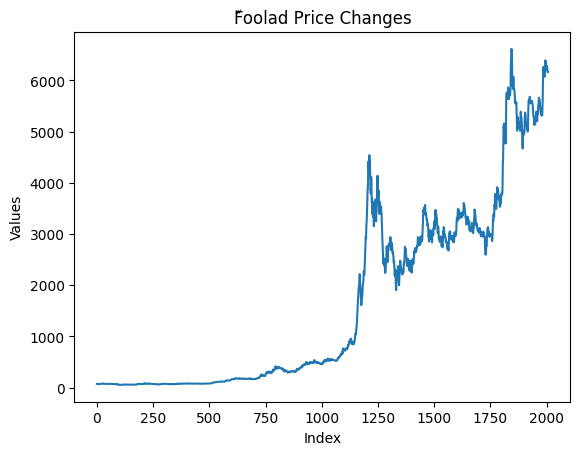

In [612]:
import numpy as np
import matplotlib.pyplot as plt


x_values = np.arange(len(merged_Foolad))

# Plotting the array
plt.plot(x_values, merged_Foolad)
plt.xlabel('Index')
plt.ylabel('Values')
plt.title('ّFoolad Price Changes')
plt.show()



<h2>data[0,:] : Foolad<h2>
data[1,:] : Shakhese Kol <h2>
data[2,:] : Shakhese Ham Vazn <h2>
data[3,:] : Common Dates <h2>
data[4,:] : Labels <h2>


## 3. Normalize Features

In [613]:
data = data.T
features = data[:, :3].astype(np.float64)  # Convert features to float64
labels = data[:, 4].astype(np.int64)  # Convert labels to int64 for classification

# Normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
features = scaler.fit_transform(features)


## 4.Create data windows

In [614]:
# Create data windows
def create_windows(data, window_size):
    windows = []
    targets = []
    for i in range(len(data) - window_size):
        window = data[i:i+window_size, :3]  # Extract only the first 3 columns (features)
        target = data[i+window_size, -1]  # Extract the label from the last column
        windows.append(window)
        targets.append(target)
    return torch.tensor(windows), torch.tensor(targets, dtype=torch.long)  # Use dtype=torch.long for classification labels


## 5. Split data and adjust window size

In [615]:
window_size = 5  # Adjust as needed
X, y = create_windows(np.hstack((features, labels.reshape(-1, 1))), window_size)

# Split into training and testing sets
train_size = int(len(X) * 0.80)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

## 6. Define RNN Model

In [616]:
class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN, self).__init__()
        self.hidden_size = hidden_size
        self.rnn = nn.LSTM(input_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        out, _ = self.rnn(x)
        out = self.fc(out[:, -1, :])
        return out

In [617]:
input_size = 3  # Since there are 3 features
hidden_size = 50  # Adjust as needed
output_size = 2  # Two classes: increase and decrease
model = RNN(input_size, hidden_size, output_size)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

## 7. Training

In [618]:
num_epochs = 50  # Adjust as needed
for epoch in range(num_epochs):

    outputs = model(X_train.float())
    optimizer.zero_grad()
    loss = criterion(outputs, y_train)
    loss.backward()
    optimizer.step()
    print('Epoch: {} \tTraining Loss: {:.6f}'.format(
        epoch+1,
        loss.item()
        ))


Epoch: 1 	Training Loss: 0.703499
Epoch: 2 	Training Loss: 0.700721
Epoch: 3 	Training Loss: 0.698094
Epoch: 4 	Training Loss: 0.695609
Epoch: 5 	Training Loss: 0.693258
Epoch: 6 	Training Loss: 0.691032
Epoch: 7 	Training Loss: 0.688924
Epoch: 8 	Training Loss: 0.686925
Epoch: 9 	Training Loss: 0.685026
Epoch: 10 	Training Loss: 0.683221
Epoch: 11 	Training Loss: 0.681501
Epoch: 12 	Training Loss: 0.679862
Epoch: 13 	Training Loss: 0.678299
Epoch: 14 	Training Loss: 0.676809
Epoch: 15 	Training Loss: 0.675390
Epoch: 16 	Training Loss: 0.674041
Epoch: 17 	Training Loss: 0.672761
Epoch: 18 	Training Loss: 0.671551
Epoch: 19 	Training Loss: 0.670413
Epoch: 20 	Training Loss: 0.669348
Epoch: 21 	Training Loss: 0.668357
Epoch: 22 	Training Loss: 0.667444
Epoch: 23 	Training Loss: 0.666610
Epoch: 24 	Training Loss: 0.665856
Epoch: 25 	Training Loss: 0.665181
Epoch: 26 	Training Loss: 0.664585
Epoch: 27 	Training Loss: 0.664062
Epoch: 28 	Training Loss: 0.663605
Epoch: 29 	Training Loss: 0.6

## 8. Test

In [619]:
model.eval()
with torch.no_grad():
    test_outputs = model(X_test.float())
    predicted_labels = torch.argmax(test_outputs, dim=1).numpy()

# Print or use 'predicted_labels' for further analysis
predicted_labels = np.where(predicted_labels == 0 ,-1,1)
y_test = np.where(y_test == 0 ,-1,1)

print(predicted_labels)


[ 1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1

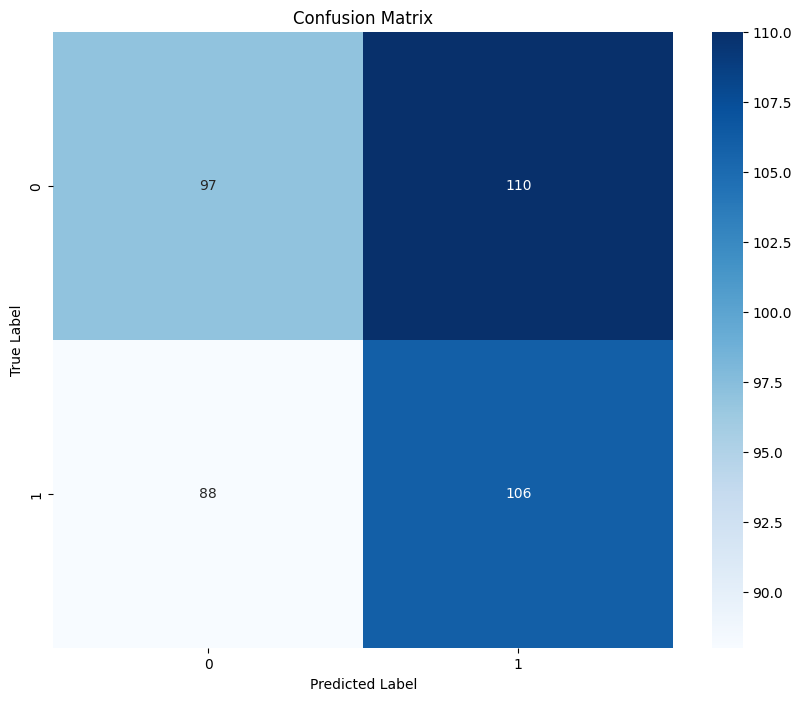

In [620]:
from sklearn.metrics import confusion_matrix
# a = np.array(*predicted_labels)
conf_matrix = confusion_matrix(y_test, predicted_labels)
import seaborn as sns
# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

# Predict with CNN

In [630]:
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import MinMaxScaler

# Assuming your data is stored in a numpy array named 'data'
# Columns 0 to 2 are features, and column 3 is the label (increase or decrease)
# Replace 'your_data.npy' with the actual file name or provide the data accordingly

# Load and preprocess the data
features = data[:, :3].astype(np.float64)  # Convert features to float64
labels = data[:, 4].astype(np.int64)  # Convert labels to int64 for classification

# Normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
features = scaler.fit_transform(features)

# Create data windows
def create_windows(data, window_size):
    windows = []
    targets = []
    for i in range(len(data) - window_size):
        window = data[i:i+window_size, :3]  # Extract only the first 3 columns (features)
        target = data[i+window_size, -1]  # Extract the label from the last column
        windows.append(window)
        targets.append(target)
    return torch.tensor(windows), torch.tensor(targets, dtype=torch.long)  # Use dtype=torch.long for classification labels

window_size = 10  # Adjust as needed
X, y = create_windows(np.hstack((features, labels.reshape(-1, 1))), window_size)

# Reshape data for CNN (add channel dimension)
X = X.unsqueeze(1)

# Split into training and testing sets
train_size = int(len(X) * 0.80)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# Define the CNN model
class CNN(nn.Module):
    def __init__(self, input_channels, output_size):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(input_channels, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.fc1 = nn.Linear(64 * 5, 128)  # Adjust the input size based on your window_size
        self.fc2 = nn.Linear(128, output_size)

    def forward(self, x):
        x = nn.functional.relu(self.conv1(x))
        x = self.pool(x)
        x = nn.functional.relu(self.conv2(x))
        x = x.view(x.size(0), -1)
        x = nn.functional.relu(self.fc1(x))
        x = self.fc2(x)
        return x

# Define the model, loss function, and optimizer
input_channels = 1  # Since we added a channel dimension
output_size = 2  # Two classes: increase and decrease
model = CNN(input_channels, output_size)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Training the model
num_epochs = 50  # Adjust as needed
for epoch in range(num_epochs):
    outputs = model(X_train.float())
    optimizer.zero_grad()
    loss = criterion(outputs, y_train)
    loss.backward()
    optimizer.step()

# Testing the model
model.eval()
with torch.no_grad():
    test_outputs = model(X_test.float())
    predicted_labels = torch.argmax(test_outputs, dim=1).numpy()

# Print or use 'predicted_labels' for further analysis
print(predicted_labels)


[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
